# Classifying Recipes: Modeling
This goal of this project is to classify recipe quality depending on the recipe's ratings and ingredients. The [dataset](https://www.kaggle.com/hugodarwood/epirecipes) was taken from Kaggle and is based off of recipes from [Epicurious](https://www.epicurious.com/recipes-menus). I will use a support vector machine classifier to make predictions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sqlalchemy import create_engine
import time
import warnings
warnings.filterwarnings('ignore')

import helpers as hp
from config import usr, pwd, url, port, db, table

%matplotlib inline

## Load Dataset
Load the cleaned dataset from the SQL database.

In [2]:
engine = create_engine(f"postgresql+psycopg2://{usr}:{pwd}@{url}:{port}/{db}")

In [3]:
query = f'''
SELECT
    *
FROM
    {table};
'''

In [4]:
df = pd.read_sql_query(query, con=engine)

In [5]:
engine.dispose()

Copy cleaned dataset to a new `DataFrame`, which will be transformed and used for modeling.

In [6]:
df_model = df.copy()

## Split by Type
As was done in the data cleaning step, let's organize this dataset by splitting it into separate variables types:
* nutrition
* keywords
* remaining

In [7]:
df_described = df_model.describe().T
nutrition_list = df_described[df_described['max'] > 5].index.tolist()
keyword_list = df_described[df_described['max'] <= 1].index.tolist()
remaining_columns = ['title', 'rating']

## Data Exploration
### Rating Distributions
Let's plot a histogram of the distribution in ratings.

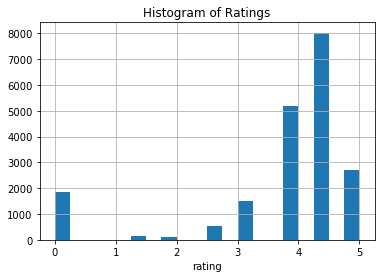

In [8]:
df_model['rating'].hist(bins=20)
plt.title('Histogram of Ratings')
plt.xlabel('rating')
plt.show()

**Observations:** Most ratings are around 4.5. There are a large number of ratings that have a value of zero.
## Feature Engineering
### 0 Value Ratings
Recipes with ratings equal to zero indicate that no one rated that recipe. Therefore, it lacks any useful information about the quality of the recipe. Therefore, I will remove any rows with a zero rating.

In [9]:
df_model = df_model[df_model['rating'] > 0].copy()

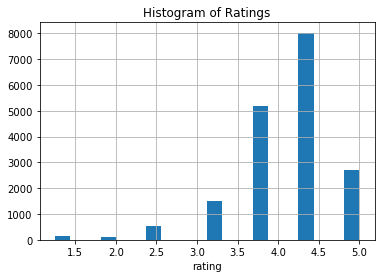

In [10]:
df_model['rating'].hist(bins=20)
plt.title('Histogram of Ratings')
plt.xlabel('rating')
plt.show()

### Binary Class
Create a column _Good_ that separates recipes into two groups, depending on their rating.

In [11]:
df_model['rating'].value_counts()

4.375    8019
3.750    5169
5.000    2719
3.125    1489
2.500     532
1.250     164
1.875     124
Name: rating, dtype: int64

In [12]:
rating_counts = df_model['rating'].value_counts()
rating_thresh = 4
num_good = rating_counts[rating_counts.index > rating_thresh].sum()
num_bad = rating_counts[rating_counts.index < rating_thresh].sum()
print(f'There are {num_good} recipes with a rating above {rating_thresh}.')
print(f'There are {num_bad} recipes with a rating below {rating_thresh}.')

There are 10738 recipes with a rating above 4.
There are 7478 recipes with a rating below 4.


I will split ratings on a threshold rating of 4.

In [13]:
df_model['good'] = df_model['rating'] > 4
df_model['good'] = df_model['good'].astype(int)
df_model['good'].unique()

array([0, 1])

I will remove the _ratings_ column as now it is redundant.

In [14]:
df_model.drop('rating', axis=1, inplace=True)

### Class Imbalance
As can be see in the rating counts, there are significantly more ratings above four than below four. To address this class imblance, I will:
* Divide the dataset into two by _good_ class.
* Take a sub-sample of the 'good' class (_good_ == 1) that is equal to the number of 'bad' labels.
* Recombine the dataset.

In [15]:
df_good = df_model[df_model['good'] == 1].copy()
df_bad = df_model[df_model['good'] == 0].copy()

In [16]:
df_good = df_good.sample(n=num_bad, random_state=42)

In [17]:
len(df_good) == len(df_bad)

True

Good. Now I have an equal number of 'good' and 'bad' labels for the _good_ column.

In [18]:
df_model = pd.concat([df_good, df_bad], axis=0)
df_model = df_model.sample(frac=1).reset_index(drop=True)

### Categorical variables
Use a $\chi$<sup>2</sup> technique to decide which categorical features have the most predictive power with _good_. Adjust threshold until feature count is less than 30. The categorical features are the keywords.

In [19]:
cat_list = hp.select_cat_variables(df_model, 'good', keyword_list, alpha=1e-5)
print(f' * will keep {len(cat_list)} categorical variables.')

Feature Chi-squared Statistics: (p-value < 1e-05)
* backyard bbq: chi2 = 34.643, p-value = 3.960e-09, dof = 1
* bon appÃ©tit: chi2 = 79.587, p-value = 4.614e-19, dof = 1
* broccoli: chi2 = 27.968, p-value = 1.234e-07, dof = 1
* cabbage: chi2 = 21.008, p-value = 4.574e-06, dof = 1
* chile pepper: chi2 = 21.144, p-value = 4.261e-06, dof = 1
* christmas: chi2 = 46.861, p-value = 7.622e-12, dof = 1
* cornmeal: chi2 = 22.913, p-value = 1.695e-06, dof = 1
* cranberry: chi2 = 21.530, p-value = 3.484e-06, dof = 1
* dinner: chi2 = 50.138, p-value = 1.433e-12, dof = 1
* goat cheese: chi2 = 23.968, p-value = 9.794e-07, dof = 1
* gourmet: chi2 = 89.536, p-value = 3.010e-21, dof = 1
* grill: chi2 = 26.605, p-value = 2.496e-07, dof = 1
* grill/barbecue: chi2 = 34.186, p-value = 5.008e-09, dof = 1
* low fat: chi2 = 44.873, p-value = 2.103e-11, dof = 1
* pasta: chi2 = 61.458, p-value = 4.522e-15, dof = 1
* quick & easy: chi2 = 80.583, p-value = 2.788e-19, dof = 1
* roast: chi2 = 61.036, p-value = 5.60

In [20]:
df_categorical = df_model.loc[:, cat_list].copy()

### Continuous variables
Compare continous features and remove those that are highly correlated with eachother. The continous variables are the nutrition variables.

In [21]:
df_model.loc[:, nutrition_list].corr()

,calories,protein,fat,sodium
calories,1.000000,0.742820,0.996538,0.996400
protein,0.742820,1.000000,0.712197,0.749298
fat,0.996538,0.712197,1.000000,0.986485
sodium,0.996400,0.749298,0.986485,1.000000


**Observations:** All continuous variables have high correlations. But, this subset includes 'missing' values, those labeled with -1. Let's remove these and redo the correlations analysis.

In [22]:
df_continuous = df_model.loc[:, nutrition_list]
df_continuous = df_continuous[((df_continuous > -1).any(axis=1))].copy()

In [23]:
df_continuous.corr()

,calories,protein,fat,sodium
calories,1.000000,0.742796,0.996538,0.996400
protein,0.742796,1.000000,0.712172,0.749272
fat,0.996538,0.712172,1.000000,0.986484
sodium,0.996400,0.749272,0.986484,1.000000


**Observations:** Even excluding the 'missing' values, the correlations between features are still pretty high. Only _calories_ and _protein_ have a correlation less than 0.8. I will only stick with the categorical variables for the model.

## Model
Define target and features.

In [24]:
X = df_model.loc[:, cat_list].values
y = df_model['good']

In [25]:
svc = SVC()

In [26]:
cv_scores = cross_val_score(svc, X, y, cv=5)
print(cv_scores)

[0.58054813 0.59324866 0.56149733 0.5632107  0.5819398 ]


## Conclusions
Well, the cross validation scores are at least greater than 50%. But, the model still does not perform well.

### Biases
Some biases in the model could include:
* High ratings
    * People who like a recipe are more likely to write a review than those who do not like it.
* Location
    * If Epicurious is mostly used in the US, then people might prefer more American recipes.
* Holiday recipes
    * These recipes tend to be more popular. Therefore, more people are more likely to write a review.
* Review counts
    * Along the same lines as the above bullet point, more popular recipes will tend to have more reviews, which in turn will tend to be more positive. Therefore, the recipes aren't being review equally, which could lead to bias.